In [7]:
pip install thefuzz

In [8]:
import pandas as pd
import numpy as np

from thefuzz import fuzz
from thefuzz import process
import re
import difflib
import seaborn as sns
import matplotlib.pyplot as plt

## Import Data

In [13]:
abilities = pd.read_excel("Abilities.xlsx")

In [12]:
skills = pd.read_excel("Skills.xlsx")

In [11]:
ai_risk = pd.read_csv("My_Data.csv")

## Review the Data

In [7]:
abilities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90792 entries, 0 to 90791
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   O*NET-SOC Code      90792 non-null  object 
 1   Title               90792 non-null  object 
 2   Element ID          90792 non-null  object 
 3   Element Name        90792 non-null  object 
 4   Scale ID            90792 non-null  object 
 5   Scale Name          90792 non-null  object 
 6   Data Value          90792 non-null  float64
 7   N                   88608 non-null  float64
 8   Standard Error      88608 non-null  float64
 9   Lower CI Bound      88608 non-null  float64
 10  Upper CI Bound      88608 non-null  float64
 11  Recommend Suppress  90792 non-null  object 
 12  Not Relevant        45396 non-null  object 
 13  Date                90792 non-null  object 
 14  Domain Source       90792 non-null  object 
dtypes: float64(5), object(10)
memory usage: 10.4+ MB


In [8]:
skills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61110 entries, 0 to 61109
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   O*NET-SOC Code      61110 non-null  object 
 1   Title               61110 non-null  object 
 2   Element ID          61110 non-null  object 
 3   Element Name        61110 non-null  object 
 4   Scale ID            61110 non-null  object 
 5   Scale Name          61110 non-null  object 
 6   Data Value          61110 non-null  float64
 7   N                   59640 non-null  float64
 8   Standard Error      59640 non-null  float64
 9   Lower CI Bound      59640 non-null  float64
 10  Upper CI Bound      59640 non-null  float64
 11  Recommend Suppress  61110 non-null  object 
 12  Not Relevant        30555 non-null  object 
 13  Date                61110 non-null  object 
 14  Domain Source       61110 non-null  object 
dtypes: float64(5), object(10)
memory usage: 7.0+ MB


In [9]:
ai_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4706 entries, 0 to 4705
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job titiles        4706 non-null   object 
 1   AI Impact          4706 non-null   object 
 2   Tasks              4706 non-null   int64  
 3   AI models          4706 non-null   int64  
 4   AI_Workload_Ratio  4706 non-null   float64
 5   Domain             4706 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 220.7+ KB


### Reconfigure the dataset to be a crosstab

In [113]:
abilities_importance = abilities[abilities["Scale Name"] == "Importance"]

In [114]:
abilities_level = abilities[abilities["Scale Name"] == "Level"]

In [115]:
skills_importance = skills[skills["Scale Name"] == "Importance"]

In [116]:
skills_level = skills[skills["Scale Name"] == "Level"]

Count how many entries (abilities and skills) there are per title in the dataset

In [117]:
## Sample title for analysis - ABILITIES
abilities_importance.loc[abilities_importance["Title"] == "Chief Executives", "Element Name"].count()

52

In [118]:
## Sample title for analysis - SKILLS

skills_importance.loc[skills_importance["Title"] == "Chief Executives", "Element Name"].count()

35

In [119]:
## Shorten the datasets for easier use
abilities_importance.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
                            "Recommend Suppress", "Not Relevant", "Date", "Domain Source"], inplace = True)
abilities_level.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
                            "Recommend Suppress", "Not Relevant", "Date", "Domain Source"], inplace = True)
skills_importance.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
                            "Recommend Suppress", "Not Relevant", "Date", "Domain Source"], inplace = True)
skills_level.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
                            "Recommend Suppress", "Not Relevant", "Date", "Domain Source"], inplace = True)

<ipython-input-119-318d0258963a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abilities_importance.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
<ipython-input-119-318d0258963a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abilities_level.drop(columns=["N", "Standard Error", "Lower CI Bound", "Upper CI Bound",
<ipython-input-119-318d0258963a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skills_imp

Create an SOC-Title Index for future use

In [120]:
SOC_codes = abilities.groupby("O*NET-SOC Code")["Title"].apply(np.unique)

In [121]:
SOC_codes_df = pd.DataFrame(SOC_codes)

In [122]:
SOC_codes_df["Adj_Title"] = SOC_codes_df.Title.apply(lambda x: ''.join([str(i) for i in x]))

In [123]:
SOC_codes_df.reset_index(inplace=True)

Create a cross tab with Titles and SOC codes

In [130]:
abilities_importance_crosstab = pd.crosstab(abilities_importance["Title"], abilities_importance["Element Name"],
                                            values=abilities_importance["Data Value"], aggfunc='mean').round(1)

In [131]:
abilities_importance_crosstab.reset_index(inplace=True)

In [132]:
abilities_importance_crosstab = abilities_importance_crosstab.merge(SOC_codes_df['O*NET-SOC Code'], left_on=['Title'], right_on=SOC_codes_df["Adj_Title"], how='inner')

In [133]:
abilities_importance_crosstab.drop(columns = ["Adj_Title"], inplace=True)

KeyError: ignored

In [135]:
abilities_level_crosstab = pd.crosstab(abilities_level["Title"], abilities_level["Element Name"],
                                            values=abilities_level["Data Value"], aggfunc='mean').round(1)

In [136]:
abilities_level_crosstab.reset_index(inplace=True)

In [137]:
skills_importance_crosstab = pd.crosstab(skills_importance["Title"], skills_importance["Element Name"],
                                values=skills_importance["Data Value"], aggfunc='mean').round(1)

In [138]:
skills_importance_crosstab.reset_index(inplace=True)

In [139]:
skills_level_crosstab = pd.crosstab(skills_level["Title"], skills_level["Element Name"],
                                values=skills_level["Data Value"], aggfunc='mean').round(1)

In [140]:
skills_level_crosstab.reset_index(inplace=True)

Combine level and importance for Abilities and Skills

In [153]:
full_dataset_occupations = abilities_importance_crosstab.merge(abilities_level_crosstab,
                                                               left_on=["Title"], right_on=["Title"], how="inner",
                                                               suffixes = ["_importance", "_level"])

In [143]:
skills_merge = skills_importance_crosstab.merge(skills_level_crosstab,
                                                left_on=["Title"], right_on=["Title"], how="inner",
                                                suffixes = ["_importance", "_level"])

In [155]:
full_dataset_occupations = full_dataset_occupations.merge(skills_merge,
                                                          left_on=["Title"], right_on=["Title"], how="inner",
                                                          )

In [156]:
list(full_dataset_occupations.columns)

['Title',
 'Arm-Hand Steadiness_importance',
 'Auditory Attention_importance',
 'Category Flexibility_importance',
 'Control Precision_importance',
 'Deductive Reasoning_importance',
 'Depth Perception_importance',
 'Dynamic Flexibility_importance',
 'Dynamic Strength_importance',
 'Explosive Strength_importance',
 'Extent Flexibility_importance',
 'Far Vision_importance',
 'Finger Dexterity_importance',
 'Flexibility of Closure_importance',
 'Fluency of Ideas_importance',
 'Glare Sensitivity_importance',
 'Gross Body Coordination_importance',
 'Gross Body Equilibrium_importance',
 'Hearing Sensitivity_importance',
 'Inductive Reasoning_importance',
 'Information Ordering_importance',
 'Manual Dexterity_importance',
 'Mathematical Reasoning_importance',
 'Memorization_importance',
 'Multilimb Coordination_importance',
 'Near Vision_importance',
 'Night Vision_importance',
 'Number Facility_importance',
 'Oral Comprehension_importance',
 'Oral Expression_importance',
 'Originality_impor

In [144]:
full_dataset_occupations = full_dataset_occupations.merge(skills_merge,
                                                          left_on=["Title"], right_on=["Title"], how="inner")

In [145]:
full_dataset_occupations.describe()

,Arm-Hand Steadiness_importance,Auditory Attention_importance,Category Flexibility_importance,Control Precision_importance,Deductive Reasoning_importance,Depth Perception_importance,Dynamic Flexibility_importance,Dynamic Strength_importance,Explosive Strength_importance,Extent Flexibility_importance,...,Science_level,Service Orientation_level,Social Perceptiveness_level,Speaking_level,Systems Analysis_level,Systems Evaluation_level,Technology Design_level,Time Management_level,Troubleshooting_level,Writing_level
count,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,...,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000,873.000000
mean,2.569530,2.382703,3.133448,2.419015,3.499427,2.165636,1.131271,1.824628,1.423139,2.015006,...,1.474112,2.852806,3.108362,3.468958,2.643872,2.634593,1.013746,3.046048,1.569072,3.303780
std,0.900414,0.447020,0.334663,0.888938,0.454273,0.611781,0.263438,0.624647,0.445483,0.816525,...,1.407799,0.627445,0.670862,0.721070,0.821884,0.858788,0.725387,0.501018,1.145156,0.850834
min,1.000000,1.100000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.900000,1.800000,1.900000,0.000000,0.100000,0.000000,1.600000,0.000000,1.000000
25%,1.900000,2.000000,3.000000,1.800000,3.100000,1.800000,1.000000,1.200000,1.000000,1.100000,...,0.200000,2.400000,2.600000,2.900000,2.000000,2.000000,0.600000,2.800000,0.500000,2.800000
50%,2.800000,2.200000,3.100000,2.400000,3.500000,2.100000,1.000000,1.900000,1.400000,2.000000,...,1.000000,2.900000,3.000000,3.600000,2.800000,2.800000,0.900000,3.000000,1.600000,3.200000
75%,3.200000,2.800000,3.200000,3.100000,3.900000,2.600000,1.100000,2.200000,1.800000,2.800000,...,2.600000,3.100000,3.600000,4.000000,3.100000,3.200000,1.200000,3.400000,2.500000,4.000000
max,4.200000,3.900000,4.000000,4.600000,4.600000,4.100000,3.600000,4.200000,3.600000,4.500000,...,5.800000,5.200000,5.800000,5.000000,5.100000,5.000000,4.100000,4.800000,4.000000,5.800000


In [15]:
ai_risk.rename(columns = {
    "Job titiles" : "Job_title"
}, inplace = True)

In [125]:
basic_lookup_in_risk_index = ai_risk[ai_risk['Job_title'].str.contains('PR')]
basic_lookup_in_risk_index

,Job_title,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain
626,CPR Instructor,50%,64,489,0.130879,Law Enforcement


In [129]:
basic_lookup_in_occupations_index = full_dataset_occupations[full_dataset_occupations["Title"].str.contains("Welder")]
basic_lookup_in_occupations_index

,Title,Arm-Hand Steadiness_importance,Auditory Attention_importance,Category Flexibility_importance,Control Precision_importance,Deductive Reasoning_importance,Depth Perception_importance,Dynamic Flexibility_importance,Dynamic Strength_importance,Explosive Strength_importance,...,Science_level,Service Orientation_level,Social Perceptiveness_level,Speaking_level,Systems Analysis_level,Systems Evaluation_level,Technology Design_level,Time Management_level,Troubleshooting_level,Writing_level
861,"Welders, Cutters, Solderers, and Brazers",3.6,2.6,2.9,3.1,3.0,2.8,1.6,2.1,2.1,...,1.0,1.5,2.1,2.0,1.8,1.5,0.8,2.2,2.1,1.5


##Clean up job titles in Occupations Dataset

In [180]:
full_dataset_occupations_copy = full_dataset_occupations.copy()

In [181]:
full_dataset_occupations_copy = [re.split(r',|, and', x) for x in full_dataset_occupations_copy["Title"]]

In [183]:
for x in full_dataset_occupations_copy:
  for y in range(len(x)):
    if x[y][-1] == "s":
      x[y] = x[y].rstrip(x[y][-1])

In [184]:
for x in full_dataset_occupations_copy:
  for y in range(len(x)):
    if x[y][-2:] == "ie":
      x[y] = re.sub(r'.{2}$',"y",x[y])

In [185]:
for x in full_dataset_occupations_copy:
  for y in range(len(x)):
      x[y] = x[y].replace('s and',"")

In [186]:
for x in full_dataset_occupations_copy:
  for y in range(len(x)):
    if x[y][0:5] == " and ":
      x[y] = re.sub(r'^.{0,5}', "", x[y])

In [187]:
for x in full_dataset_occupations_copy:
  for y in range(len(x)):
    if x[y][0] == " ":
      x[y] = x[y].strip()

In [188]:
exceptions = []
for x in full_dataset_occupations_copy:
  for y in range(len(x)):
    if "except" in x[y]:
      m = y
      for y in range(m,len(x)+1):
        exceptions.append(x[y])

Split on "," and "and":

Split occupation titles on ", and " and ", "
Replace "ie" at the end of occupations with "y"
Strip "s" at the end of occupations (problems with certain fields like "gas" and "waitresses")
Trim leading spaces
Remove all words following "except"

In [193]:
full_dataset_occupations_copy_titles = pd.DataFrame(full_dataset_occupations_copy, columns=['Title1','Title2','Title3',
                                            'Title4','Title5','Title6','Title7'])

In [194]:
full_dataset_occupations_copy_titles = full_dataset_occupations_copy_titles.merge(full_dataset_occupations["Title"],
                                                          left_index = True, right_index = True, how="inner")

In [196]:
full_dataset_occupations_copy_titles = full_dataset_occupations_copy_titles.merge(SOC_codes_df["O*NET-SOC Code"],
                                                                                  left_on=full_dataset_occupations_copy_titles["Title"], right_on=SOC_codes_df["Adj_Title"], how="inner")

In [198]:
full_dataset_occupations_copy_titles.drop(columns = ["key_0"], inplace=True)

In [200]:
full_dataset_occupations_copy_titles.isna().sum()

Title1              0
Title2            639
Title3            760
Title4            824
Title5            860
Title6            868
Title7            871
Title               0
O*NET-SOC Code      0
dtype: int64

In [42]:
full_dataset_occupations_copy_titles.to_csv('Job_Titles_US_Census.csv', index=False)

In [43]:
full_dataset_occupations_copy_titles = pd.read_csv('Job_Titles_US_Census.csv')

##Analyzing our dataset
Matching titles across datasets

In [204]:
full_dataset_occupations_copy_titles_cleaning_4_7 = full_dataset_occupations_copy_titles.loc[
    (pd.notnull(full_dataset_occupations_copy_titles.Title7)) |
    (pd.notnull(full_dataset_occupations_copy_titles.Title6)) |
    (pd.notnull(full_dataset_occupations_copy_titles.Title5)) |
    (pd.notnull(full_dataset_occupations_copy_titles.Title4))
    ]

In [206]:
# How many occupations have 4-7 title components
len(full_dataset_occupations_copy_titles_cleaning_4_7.index)

49

Patterns:
1. Assemblers; Teachers: All titles are actually one title
* Teachers with "Postsecondary" can have that be removed OR replaced with "University" OR renamed as "Professors" OR renamed as "Instructors"
2. Camera Operators: Additional titles are irrelevant and can be removed
3. Operator and Tender: Split out into separate title fields, consider joining
4. Operator and Tender: Have additional qualifiers (Metal and Plastic, Synthetic and Glass, etc.) - consider removing
5. Dispatcher: Except specific areas (consider using for manual analysis)
6. Farm worker, Artist, Helper, Glass Blower, Brickmason, Insulation Worker, Laborer, Molder: Doesn't need additional titles


In [205]:
full_dataset_occupations_copy_titles_cleaning_4_7

,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Title,O*NET-SOC Code
24,Aircraft Structure,Surface,Rigging,Systems Assembler,None,None,None,"Aircraft Structure, Surfaces, Rigging, and Sys...",51-2011.00
46,Area,Ethnic,Cultural Studies Teacher,Postsecondary,None,None,None,"Area, Ethnic, and Cultural Studies Teachers, P...",25-1062.00
49,Art,Drama,Music Teacher,Postsecondary,None,None,None,"Art, Drama, and Music Teachers, Postsecondary",25-1121.00
54,Atmospheric,Earth,Marine,Space Sciences Teacher,Postsecondary,None,None,"Atmospheric, Earth, Marine, and Space Sciences...",25-1051.00
105,Camera Operator,Television,Video,Film,None,None,None,"Camera Operators, Television, Video, and Film",27-4031.00
143,Coating,Painting,Spraying Machine Setter,Operator,Tender,None,None,"Coating, Painting, and Spraying Machine Setter...",51-9124.00
199,Crushing,Grinding,Polishing Machine Setter,Operator,Tender,None,None,"Crushing, Grinding, and Polishing Machine Sett...",51-9021.00
206,Cutting,Punching,Press Machine Setter,Operator,Tender,Metal and Plastic,None,"Cutting, Punching, and Press Machine Setters, ...",51-4031.00
229,Dispatcher,Except Police,Fire,Ambulance,None,None,None,"Dispatchers, Except Police, Fire, and Ambulance",43-5032.00
233,Drilling and Boring Machine Tool Setter,Operator,Tender,Metal and Plastic,None,None,None,"Drilling and Boring Machine Tool Setters, Oper...",51-4032.00


In [212]:
full_dataset_occupations_copy_titles_cleaning_3 = full_dataset_occupations_copy_titles.loc[
    (pd.notnull(full_dataset_occupations_copy_titles.Title3)) &
    (pd.isnull(full_dataset_occupations_copy_titles.Title4))
    ]

In [213]:
len(full_dataset_occupations_copy_titles_cleaning_3.index)

64

Some observations for roles with 3 titles:
1. Adjudicator/ Hearing Officer/ Administrative Law Judge: Some could/should be split up into 3 separate rows
2. Adult Basic Education/ESL: Some need to be renamed
3. Agent: Some can have extra titles removed
4. Transportation Storage Distribution Manager: Some need to be combined into one title
5. Anything with "Except": Some need to be shortened

In [214]:
full_dataset_occupations_copy_titles_cleaning_3

,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Title,O*NET-SOC Code
7,Administrative Law Judge,Adjudicator,Hearing Officer,None,None,None,None,"Administrative Law Judges, Adjudicators, and H...",23-1021.00
9,Adult Basic Education,Adult Secondary Education,English as a Second Language Instructor,None,None,None,None,"Adult Basic Education, Adult Secondary Educati...",25-3011.00
15,Agent Business Managers of Artist,Performer,Athlete,None,None,None,None,"Agents and Business Managers of Artists, Perfo...",13-1011.00
26,Airline Pilot,Copilot,Flight Engineer,None,None,None,None,"Airline Pilots, Copilots, and Flight Engineers",53-2011.00
40,Arbitrator,Mediator,Conciliator,None,None,None,None,"Arbitrators, Mediators, and Conciliators",23-1022.00
...,...,...,...,...,...,...,...,...,...
824,Tool Grinder,Filer,Sharpener,None,None,None,None,"Tool Grinders, Filers, and Sharpeners",51-4194.00
835,Transportation Vehicle,Equipment and Systems Inspector,Except Aviation,None,None,None,None,"Transportation Vehicle, Equipment and Systems ...",53-6051.07
836,Transportation,Storage,Distribution Manager,None,None,None,None,"Transportation, Storage, and Distribution Mana...",11-3071.00
842,Umpire,Referee,Other Sports Official,None,None,None,None,"Umpires, Referees, and Other Sports Officials",27-2023.00


Trying Fuzzy Match

In [9]:
full_dataset_occupations_copy_titles["Match_Column"] = full_dataset_occupations_copy_titles["Title"]

In [44]:
full_dataset_occupations_copy_titles.columns

Index(['Unnamed: 0', 'Title1', 'Title2', 'Title3', 'Title4', 'Title5',
       'Title6', 'Title7', 'Title', 'O*NET-SOC Code', 'Match_Column',
       'Match_Ratio', 'Match_Column_unpacked', 'Match_Column_1'],
      dtype='object')

In [45]:
full_dataset_occupations_copy_titles.drop(columns = ["Unnamed: 0"], inplace=True)

In [21]:
ai_risk.columns

Index(['Job_title', 'AI Impact', 'Tasks', 'AI models', 'AI_Workload_Ratio',
       'Domain'],
      dtype='object')

In [46]:
full_dataset_occupations_copy_titles["Match_Column"]= full_dataset_occupations_copy_titles["Title"].apply(lambda x: difflib.get_close_matches(x, ai_risk["Job_title"]))


In [34]:
full_dataset_occupations_copy_titles["Match_Column_unpacked"] = full_dataset_occupations_copy_titles["Match_Column"].apply("|".join)

In [35]:
full_dataset_occupations_copy_titles["Match_Ratio"] = full_dataset_occupations_copy_titles.apply(lambda x: fuzz.ratio(x.Match_Column_unpacked, x.Title), axis=1)

In [81]:
full_dataset_occupations_copy_titles["Match_Ratio_tokens"]= full_dataset_occupations_copy_titles.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_unpacked, x.Title), axis=1)

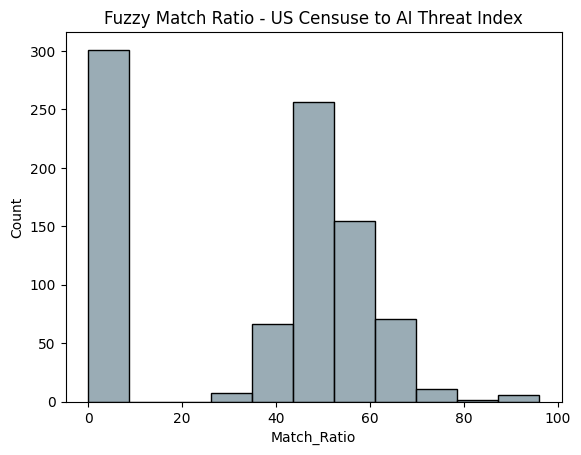

In [37]:
fig = plt.plot(figsize=(8, 8))

sns.histplot(data=full_dataset_occupations_copy_titles, x=full_dataset_occupations_copy_titles["Match_Ratio"], color='#78909c').set(title='Fuzzy Match Ratio - US Censuse to AI Threat Index');


In [50]:
full_dataset_occupations_copy_titles["Title1"][1]

'Actor'

In [51]:
full_dataset_occupations_copy_titles["Title"][1]

'Actors'

In [52]:
full_dataset_occupations_copy_titles["Match_Column_1"]= full_dataset_occupations_copy_titles["Title1"].apply(lambda x: difflib.get_close_matches(x, ai_risk["Job_title"]))


In [53]:
full_dataset_occupations_copy_titles["Match_Column_1_unpacked"] = full_dataset_occupations_copy_titles["Match_Column_1"].apply("|".join)

In [73]:
full_dataset_occupations_copy_titles["Match_Ratio_1"] = full_dataset_occupations_copy_titles.apply(lambda x: fuzz.ratio(x.Match_Column_1_unpacked, x.Title1), axis=1)

In [82]:
full_dataset_occupations_copy_titles["Match_Ratio_1_tokens"]= full_dataset_occupations_copy_titles.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_1_unpacked, x.Title1), axis=1)

In [85]:
full_dataset_occupations_copy_titles["Match_Ratio_1b_tokens"]= full_dataset_occupations_copy_titles.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_1_unpacked, x.Title), axis=1)

In [86]:
full_dataset_occupations_copy_titles.sort_values(by=['Match_Ratio'], ascending=False)

,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Title,O*NET-SOC Code,Match_Column,Match_Ratio,Match_Column_unpacked,Match_Column_1,Match_Column_1_unpacked,Match_Ratio_1,Match_Ratio_1_tokens,Match_Ratio_tokens,Match_Ratio_1b_tokens
3,Acupuncturist,NaN,NaN,NaN,NaN,NaN,NaN,Acupuncturists,29-1291.00,[Acupuncturist],96,Acupuncturist,"[Acupuncturist, Manicurist]",Acupuncturist|Manicurist,70,70,96,74
533,Millwright,NaN,NaN,NaN,NaN,NaN,NaN,Millwrights,49-9044.00,[Millwright],95,Millwright,[Millwright],Millwright,100,100,95,95
262,Embalmer,NaN,NaN,NaN,NaN,NaN,NaN,Embalmers,39-4011.00,[Embalmer],94,Embalmer,"[Embalmer, Gamer]",Embalmer|Gamer,73,73,94,70
67,Bailiff,NaN,NaN,NaN,NaN,NaN,NaN,Bailiffs,33-3011.00,[Bailiff],93,Bailiff,[Bailiff],Bailiff,100,100,93,93
70,Barista,NaN,NaN,NaN,NaN,NaN,NaN,Baristas,35-3023.01,[Barista],93,Barista,"[Barista, Priest, Artist]",Barista|Priest|Artist,50,50,93,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,First-Line Supervisors of Material-Moving Mach...,NaN,NaN,NaN,NaN,NaN,NaN,First-Line Supervisors of Material-Moving Mach...,53-1043.00,[],0,NaN,[],,0,0,8,0
644,Plumber,Pipefitter,Steamfitter,NaN,NaN,NaN,NaN,"Plumbers, Pipefitters, and Steamfitters",47-2152.00,[],0,NaN,"[Plumber, Pumper, Plumber Helper]",Plumber|Pumper|Plumber Helper,39,39,10,48
643,Plating Machine Setter,Operator,Tender,Metal and Plastic,NaN,NaN,NaN,"Plating Machine Setters, Operators, and Tender...",51-4193.00,[],0,NaN,"[Packaging Machine Operator, Sewing Machine Op...",Packaging Machine Operator|Sewing Machine Oper...,44,40,9,60
642,Plasterer Stucco Mason,NaN,NaN,NaN,NaN,NaN,NaN,Plasterers and Stucco Masons,47-2161.00,[],0,NaN,[],,0,0,19,0


In [63]:
full_dataset_occupations_copy_titles["Match_Ratio_1_tokens"].value_counts(ascending= False).head()

0     116
49     46
52     45
51     39
55     39
Name: Match_Ratio_1_tokens, dtype: int64

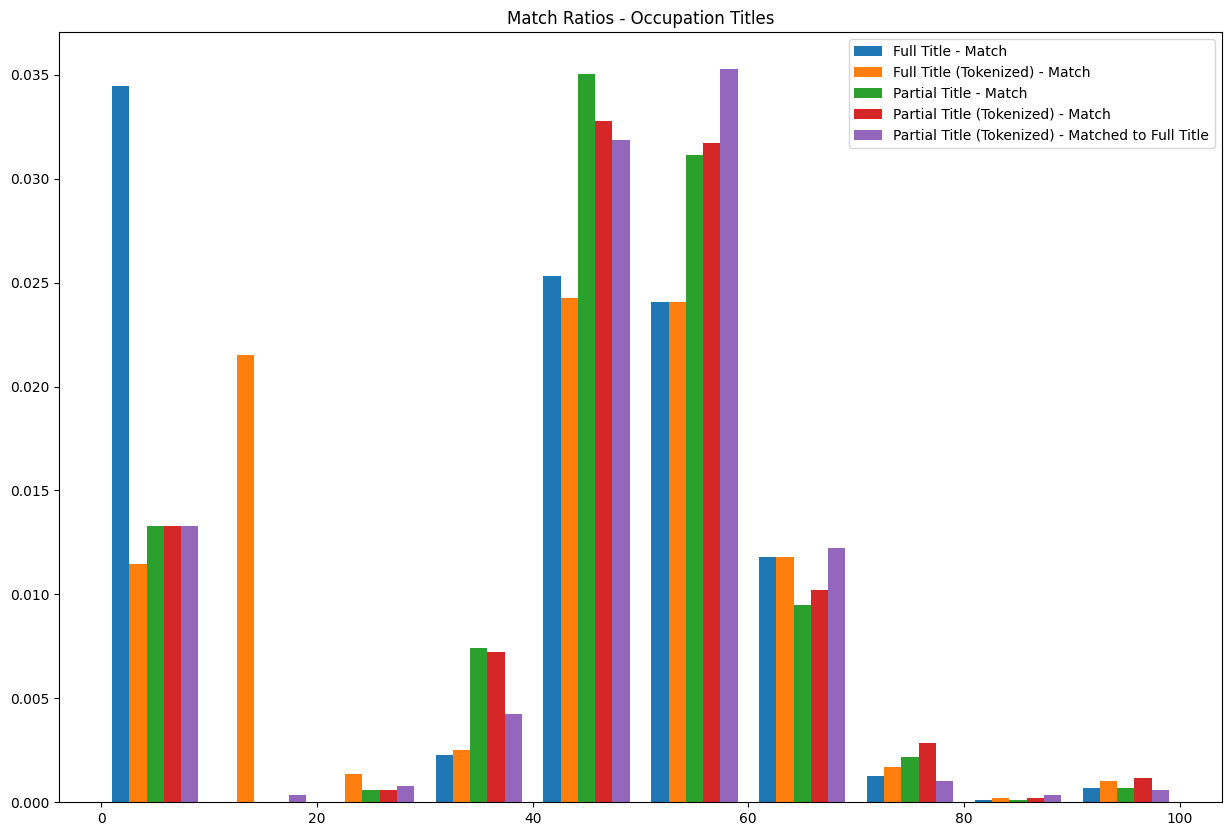

In [90]:
x = full_dataset_occupations_copy_titles[["Match_Ratio", "Match_Ratio_tokens", "Match_Ratio_1","Match_Ratio_1_tokens","Match_Ratio_1b_tokens"]]
plt.figure(figsize=(15,10))
plt.hist(x, density=True, histtype='bar')
plt.title('Match Ratios - Occupation Titles')
plt.legend(["Full Title - Match", "Full Title (Tokenized) - Match","Partial Title - Match", "Partial Title (Tokenized) - Match", "Partial Title (Tokenized) - Matched to Full Title"], loc ="upper right", fontsize = '10');

In [22]:
ai_risk["Match_Column"] = ai_risk["Job_title"]

In [26]:
ai_risk["Match_Column"] = ai_risk["Job_title"].apply(lambda x: difflib.get_close_matches(x, full_dataset_occupations_copy_titles["Title"]))

In [29]:
ai_risk["Match_Column_unpacked"] = ai_risk["Match_Column"].apply("|".join)

In [30]:
ai_risk["Match_Ratio"] =  ai_risk.apply(lambda x: fuzz.ratio(x.Match_Column_unpacked, x.Job_title), axis=1)

In [91]:
ai_risk["Match_Ratio_tokens"]= ai_risk.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_unpacked, x.Job_title), axis=1)

In [92]:
ai_risk.sort_values(by=['Match_Ratio'], ascending=False)

,Job_title,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain,Match_Column,Match_Ratio,Match_Column_unpacked,Match_Ratio_tokens
75,Printing Press Operator,80%,93,1065,0.087324,Supply Chain & Logistics,[Printing Press Operators],98,Printing Press Operators,98
909,Insurance Underwriter,45%,464,1553,0.298777,Hospitality,[Insurance Underwriters],98,Insurance Underwriters,98
4336,Air Traffic Controller,10%,372,1553,0.239536,Law Enforcement,[Air Traffic Controllers],98,Air Traffic Controllers,98
2619,Community Health Worker,25%,227,1556,0.145887,Hospitality,[Community Health Workers],98,Community Health Workers,98
15,Medical Transcriptionist,90%,189,1265,0.149407,Supply Chain & Logistics,[Medical Transcriptionists],98,Medical Transcriptionists,98
...,...,...,...,...,...,...,...,...,...,...
3798,Senior Staff Accountant,15%,941,3944,0.238590,Sales & Marketing,[],0,,0
2933,Refinery,20%,110,817,0.134639,Leadership & Strategy,[],0,,0
2935,Stockroom Clerk,20%,183,1350,0.135556,Supply Chain & Logistics,[],0,,0
3795,Inventory Supervisor,15%,913,3625,0.251862,Supply Chain & Logistics,[],0,,0


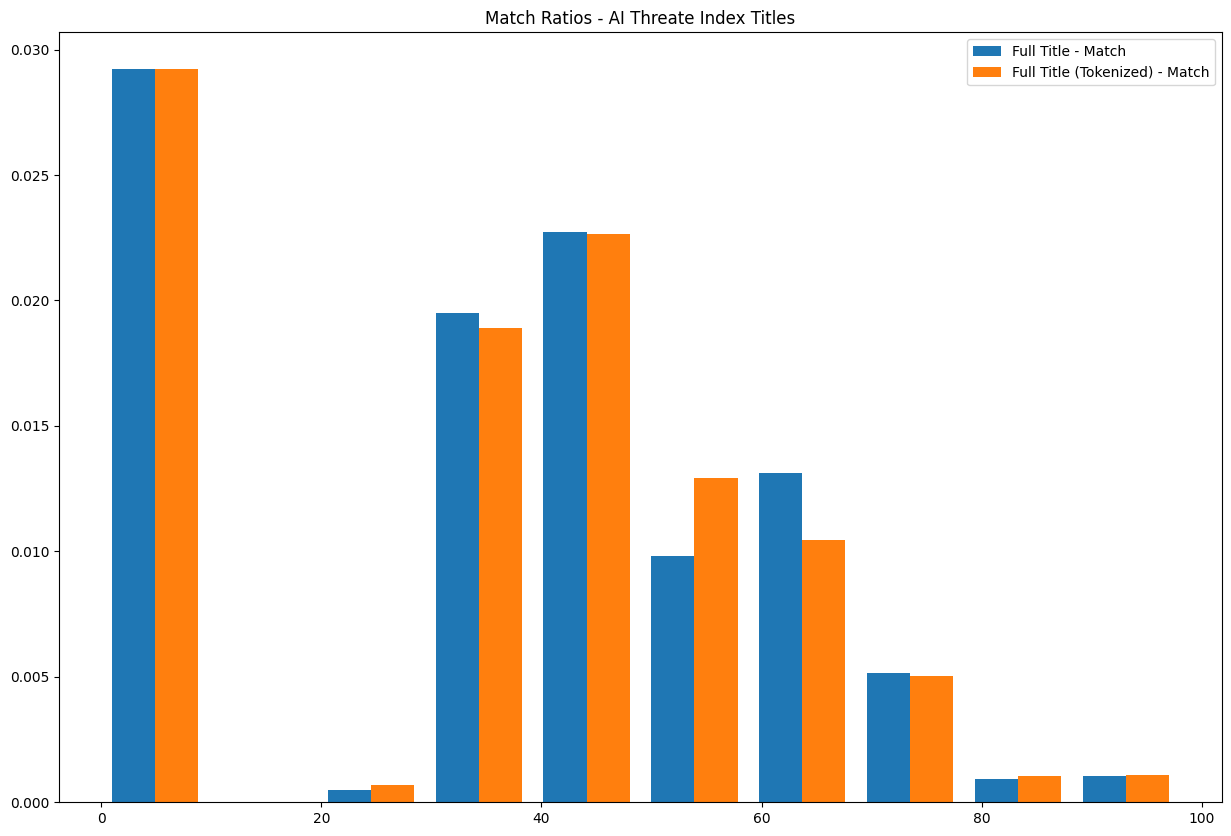

In [93]:
x = ai_risk[["Match_Ratio", "Match_Ratio_tokens"]]
plt.figure(figsize=(15,10))
plt.hist(x, density=True, histtype='bar')
plt.title('Match Ratios - AI Threate Index Titles')
plt.legend(["Full Title - Match", "Full Title (Tokenized) - Match"], loc ="upper right", fontsize = '10');


In [65]:
mean_similarity = np.mean(ai_risk["Match_Ratio"])
mean_similarity

35.31534211644709

In [99]:
filtered_job_threat_index = ai_risk[ai_risk["Match_Ratio"] <= 50].shape[0]
print(filtered_census, round(filtered_job_threat_index/ai_risk.shape[0],2))

523 0.73


In [95]:
mean_similarity_ = np.mean(full_dataset_occupations_copy_titles["Match_Ratio_1_tokens"])
mean_similarity_

44.241695303550976

In [98]:
filtered_census = full_dataset_occupations_copy_titles[full_dataset_occupations_copy_titles["Match_Ratio_1_tokens"] <= 50].shape[0]
print(filtered_census, round(filtered_census/full_dataset_occupations_copy_titles.shape[0],2))

523 0.6


## Feeding in the Target Values

In [102]:
full_dataset_occupations_copy_titles_analysis = full_dataset_occupations_copy_titles.loc[(full_dataset_occupations_copy_titles.Match_Ratio_1_tokens >=50)]

In [103]:
full_dataset_occupations_copy_titles_analysis.head()

,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Title,O*NET-SOC Code,Match_Column,Match_Ratio,Match_Column_unpacked,Match_Column_1,Match_Column_1_unpacked,Match_Ratio_1,Match_Ratio_1_tokens,Match_Ratio_tokens,Match_Ratio_1b_tokens
3,Acupuncturist,NaN,NaN,NaN,NaN,NaN,NaN,Acupuncturists,29-1291.00,[Acupuncturist],96,Acupuncturist,"[Acupuncturist, Manicurist]",Acupuncturist|Manicurist,70,70,96,74
5,Adapted Physical Education Specialist,NaN,NaN,NaN,NaN,NaN,NaN,Adapted Physical Education Specialists,25-2059.01,"[Education Specialist, Medical Information Spe...",48,Education Specialist|Medical Information Speci...,"[Education Specialist, Medical Information Spe...",Education Specialist|Medical Information Speci...,49,57,59,59
6,Adhesive Bonding Machine Operator Tender,NaN,NaN,NaN,NaN,NaN,NaN,Adhesive Bonding Machine Operators and Tenders,51-9191.00,[Sewing Machine Operator],61,Sewing Machine Operator,"[Sewing Machine Operator, Packaging Machine Op...",Sewing Machine Operator|Packaging Machine Oper...,52,52,55,51
7,Administrative Law Judge,Adjudicator,Hearing Officer,NaN,NaN,NaN,NaN,"Administrative Law Judges, Adjudicators, and H...",23-1021.00,[],0,NaN,"[Administrative Law Judge, Administrative Mana...",Administrative Law Judge|Administrative Manage...,52,52,10,61
8,Administrative Services Manager,NaN,NaN,NaN,NaN,NaN,NaN,Administrative Services Managers,11-3012.00,"[Administrative Services Manager, Administrati...",57,Administrative Services Manager|Administrative...,"[Administrative Services Manager, Administrati...",Administrative Services Manager|Administrative...,55,55,57,57


In [107]:
def partial_match(x):
    return ai_risk.loc[ai_risk['Job_title'].str.contains(x), 'AI Impact'].iloc[0]

In [108]:
full_dataset_occupations_copy_titles_analysis['ai_impact'] = full_dataset_occupations_copy_titles_analysis['Match_Column_1_unpacked'].apply(partial_match)

<ipython-input-108-4fa319f9e50b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_dataset_occupations_copy_titles_analysis['ai_impact'] = full_dataset_occupations_copy_titles_analysis['Match_Column_1_unpacked'].apply(partial_match)


In [110]:
full_dataset_occupations_copy_titles_analysis.shape[0]

403

In [112]:
full_dataset_occupations_copy_titles_analysis["ai_impact"].str.rstrip('%')

3      10
5      45
6      45
7      85
8      50
       ..
868    43
869    25
870    80
871    40
872    15
Name: ai_impact, Length: 403, dtype: object

In [158]:
full_dataset_occupations_with_target = full_dataset_occupations.merge(full_dataset_occupations_copy_titles_analysis,
                                                                                  left_on=full_dataset_occupations["O*NET-SOC Code"], right_on=full_dataset_occupations_copy_titles_analysis["O*NET-SOC Code"], how="inner")

In [163]:
drop_features = ['Title1',
 'Title2',
 'Title3',
 'Title4',
 'Title5',
 'Title6',
 'Title7',
 'Title_y',
 'O*NET-SOC Code_y',
 'O*NET-SOC Code_x',
 'Match_Column',
 'Match_Ratio',
 'Match_Column_unpacked',
 'Match_Column_1',
 'Match_Column_1_unpacked',
 'Match_Ratio_1',
 'Match_Ratio_1_tokens',
 'Match_Ratio_tokens',
 'Match_Ratio_1b_tokens',
 'ai_impact',
 'Title_x',
  'key_0']

In [164]:
X = full_dataset_occupations_with_target.drop(columns=drop_features)

In [169]:
y = full_dataset_occupations_with_target["ai_impact"].str.rstrip('%')

In [170]:
y

0      10
1      45
2      45
3      85
4      50
       ..
398    43
399    25
400    80
401    40
402    15
Name: ai_impact, Length: 403, dtype: object

In [166]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,make_scorer,recall_score, accuracy_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)


Trying a straightforward Logistic Regression

In [173]:
logr = LogisticRegression()

In [174]:
logr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [175]:
print(logr.score(X_train, y_train))
print(logr.score(X_test, y_test))

0.7682119205298014
0.12871287128712872


A pretty sad model here - will need a lot of work to get this in shape.